# 개와 고양이 이진 분류
---
- 로컬PC에 저장되어있는 이미지 데이터를 로딩해서 학습시키기
- GPU 사용
- [모델 작성 참고](https://github.com/raahatg21/Cats-and-Dogs-Dataset-with-Keras/blob/master/Cats_Dogs_9439.ipynb)

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### 1.데이터 준비

In [140]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [141]:
# !unzip cats_and_dogs_filtered.zip

In [142]:
"""data_root = '/content/cats_and_dogs_filtered'
train_dir = '/content/cats_and_dogs_filtered/train'
val_dir = '/content/cats_and_dogs_filtered/validation'"""

data_root = './cats_and_dogs_filtered'
train_dir = './cats_and_dogs_filtered/train'
val_dir = './cats_and_dogs_filtered/validation'

In [143]:
import os

# 파일명 리스트 획득

train_cats_fname = os.listdir(os.path.join(train_dir, 'cats'))
train_dogs_fname = os.listdir(os.path.join(train_dir, 'dogs'))

test_cats_fname = os.listdir(os.path.join(val_dir, 'cats'))
test_dogs_fname = os.listdir(os.path.join(val_dir, 'dogs'))

print('train cats:', len(train_cats_fname))
print('train dogs:', len(train_dogs_fname))

print('test cats:', len(test_cats_fname))
print('test dogs:', len(test_dogs_fname))

train cats: 1000
train dogs: 1000
test cats: 500
test dogs: 500


- 레이블명

In [144]:
class_name = ['cat', 'dog']

In [145]:
import PIL

X_train = []
y_train = []

for i in range(len(train_cats_fname)):
    f = os.path.join(train_dir, 'cats', train_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(0)

for i in range(len(train_dogs_fname)):
    f = os.path.join(train_dir, 'dogs', train_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(1)

In [146]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

(2000, 224, 224, 3) (2000,)


In [147]:
X_val = []
y_val = []

for i in range(len(test_cats_fname)):
    f = os.path.join(val_dir, 'cats', test_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(0)

for i in range(len(test_dogs_fname)):
    f = os.path.join(val_dir, 'dogs', test_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(1)

In [148]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape, y_val.shape)

(1000, 224, 224, 3) (1000,)


### Data Ready

In [149]:
# data suffle
index = np.arange(0, len(X_train))
np.random.shuffle(index)
X_train = X_train[index]
y_train = y_train[index]

index = np.arange(0, len(X_val))
np.random.shuffle(index)
X_val = X_val[index]
y_val = y_val[index]

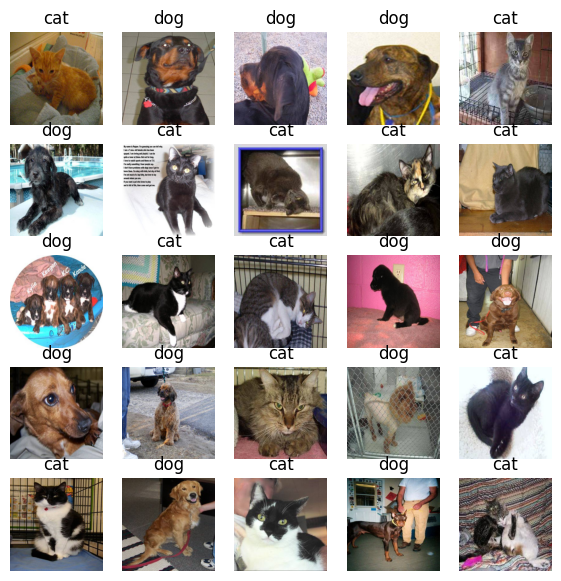

In [150]:
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_name[y_train[i]])
    plt.axis('off')

### Normalization

In [151]:
X_train_s = X_train / 255.
X_val_s = X_val / 255.

print(np.max(X_train_s), np.min(X_train_s))

1.0 0.0


### Data Augmentation

In [152]:
def data_augmentation(X, y):
    X_flip = np.flip(X, axis=2)
    X_rot = np.rot90(X, axes=(1, 2))
    X = np.concatenate((X, X_flip, X_rot), axis=0)
    y = np.concatenate((y, y, y), axis=0)
    return X, y

X_train_s, y_train = data_augmentation(X_train_s, y_train)

In [153]:
# data suffle again
index = np.arange(0, len(X_train_s))
np.random.shuffle(index)
X_train_s = X_train_s[index]
y_train = y_train[index]

### One Hot Encoding

In [154]:
from keras.utils import to_categorical

y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

y_train_o[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Checkout

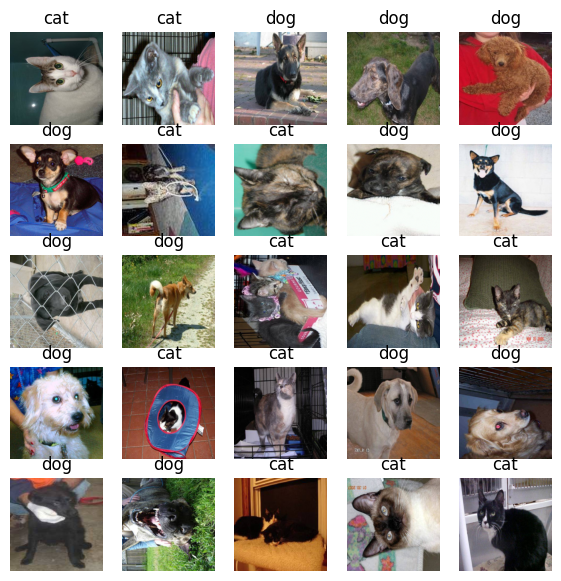

In [155]:
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_s[5000 + i])
    plt.title(class_name[np.argmax(y_train_o[5000 + i])])
    plt.axis('off')

In [156]:
print(X_train_s.shape, y_train_o.shape)

(6000, 224, 224, 3) (6000, 2)


### Model

In [157]:
from keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [158]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 128)     

In [159]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [160]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3
)

In [161]:
EPOCHS = 15
BATCH_SIZE = 16

history = model.fit(
    X_train_s, y_train_o,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_s, y_val_o),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/16
375/375 [==============================] - 16s 39ms/step - loss: 0.6939 - accuracy: 0.5100 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 2/16
375/375 [==============================] - 11s 29ms/step - loss: 0.6732 - accuracy: 0.5703 - val_loss: 0.6130 - val_accuracy: 0.6530
Epoch 3/16
375/375 [==============================] - 11s 29ms/step - loss: 0.6219 - accuracy: 0.6520 - val_loss: 0.5754 - val_accuracy: 0.6950
Epoch 4/16
375/375 [==============================] - 11s 30ms/step - loss: 0.5401 - accuracy: 0.7227 - val_loss: 0.5607 - val_accuracy: 0.7130
Epoch 5/16
375/375 [==============================] - 11s 30ms/step - loss: 0.4696 - accuracy: 0.7772 - val_loss: 0.5009 - val_accuracy: 0.7470
Epoch 6/16
375/375 [==============================] - 11s 30ms/step - loss: 0.4059 - accuracy: 0.8135 - val_loss: 0.4787 - val_accuracy: 0.7880
Epoch 7/16
375/375 [==============================] - 11s 30ms/step - loss: 0.3178 - accuracy: 0.8625 - val_loss: 0.5530 - val_accuracy:

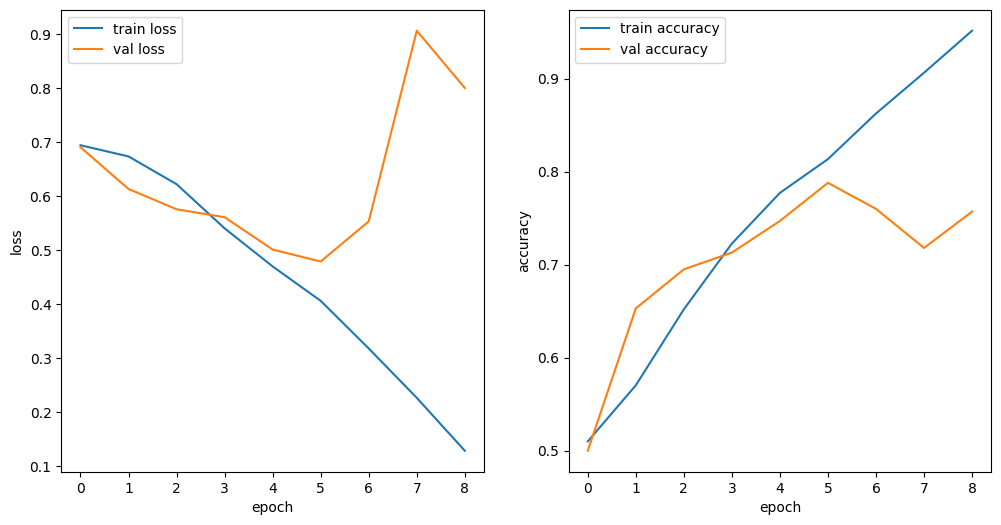

In [162]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.show()

plot_history(history)

In [163]:
model.save('cats_and_dogs.keras')

In [165]:
model.evaluate(X_val_s, y_val_o)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.